# Example: Modeling the Payout and Profit of Long and Short American-style Put Contracts

## Background
A `put` option is a financial contract that gives the holder the right, but not the obligation, to sell a specified asset, such as stocks, commodities, or currencies, at a predetermined price within a specified time period. Let's consider stock as the underlying asset. A single standard `put` contract controls `100` shares of stock.

In the case of [American](https://www.investopedia.com/terms/a/americanoption.asp) style [put contracts](https://www.investopedia.com/terms/p/putoption.asp), the option buyer can exercise their right at any point between when the contract is purchased and the expiration date. On the other hand, buyers of [European](https://www.investopedia.com/terms/e/europeanoption.asp) style contracts can only exercise their right on the expiration date. 

The business case for buying (or selling) `put` contracts:
* __Buyer (long)__: From the buyer's perspective, `put` contracts allow an investor to benefit from the price movement of `XYZ` to the downside _without_ purchasing `XYZ`. Further, `put` options (again from the buyer's perspective) have _limited downside risk_, i.e., the maximum amount that the holder of the `put` option can lose is the premium paid for the option. Finally, `put` contracts are a mechanism to sell shares of `XYZ` at the strike price of $K$ instead of the market price of $S$. 
* __Seller (short)__: From the seller's perspective, the motivation for selling a `put` contract is to collect the premium $\mathcal{P}$. Put contracts also allow the seller to benefit from the price movement of `XYZ` to the upside _without_ purchasing `XYZ`. However, for a seller, `put` options have _unlimted downside_ risk; thus, `put` options are often only sold by investors who have set aside the required capital to purchase the required number of shares of `XYZ` (known as a [cash secured put position](https://www.fidelity.com/learning-center/investment-products/options/know-about-cash-covered-puts)). Finally, `put` options offer the seller the opportunity to buy shares of `XYZ` at the strike price of $K-\mathcal{P}$ instead of the market price of $S$.

## Payoff, Profit and Premium
The payoff of a `put` contract at expiration `T` days in the future is defined as

$$V_{p}(K,S(T)) = \max\left(K - S(T),~0.0\right)$$

where $K$ denotes the strike price and $S(T)$ denotes the share price of the underlying asset `T` days in the future (at expiration). The right (but not the obligation) to sell shares is not free, the seller charges the buyer a preimum for each `put` contract $\mathcal{P}_{p}$. Thus, from the perspective of the buyer, the profit for the `put` contract $P_{p}$ is given by:

$$P_{p}(K,S(T)) = \hat{V}_{p}(K,S(T)) -  \mathcal{P}_{p}(K,S(T))$$

Finally, the premium (cost) for each `put` contract $\mathcal{P}_{p}(\dots)$ is defined by the expression:

$$\mathcal{P}_{p}(K,S(T))\geq\mathbb{E}\Bigl(\mathcal{D}^{-1}_{T,0}(\bar{r})\cdot{V_{p}}(K,S(T)\Bigr)$$

where $\mathcal{D}_{T,0}(\bar{r})$ denotes the discount rate between the time when the contract was purchased `0` and contract expiration `T` days in the future. Option contracts using risk neutral pricing, thus, the discount rate $\bar{r}$ is typially taken as the interest rate on 10-year treasury notes. 

## Setup
Fill me in.

In [1]:
include("Include.jl")

profit (generic function with 1 method)

## Objectives
In this example, we'll compute the premium, payoff and profit for sample `put` option contracts. In particular:

* __Objective 1__: We'll begin with [European](https://www.investopedia.com/terms/e/europeanoption.asp) style contracts, where the contract can only be excersised at expiration. 
* __Objective 2__: We'll then contrast this perspective with [American](https://www.investopedia.com/terms/a/americanoption.asp) style `put` contracts where a contract can be excercised at any point between when the contract was purchased and expiration. 

## Objective 1: Premium, payoff and profit for a European Put contract

Let's begin by computing the premium $\mathcal{P}_{p}(K,S(T))$ the buyer must pay for a `put` contract. When early excersise is not allowed, the pricing formula is given by (the equality case):

$$\mathcal{P}_{p}(K,S(T)) = \mathbb{E}\Bigl(\mathcal{D}^{-1}_{T,0}(\bar{r})\cdot{V_{p}}(K,S(T))\Bigr)$$

which says the right (but not the obligation) to excercise the `put` contract is the expected value of the discounted future payoff from the contract. To compute the expectation, we simulate the future share price `T` days in the future using a [geometric Brownian motion](https://en.wikipedia.org/wiki/Geometric_Brownian_motion#:~:text=A%20geometric%20Brownian%20motion%20(GBM,a%20Wiener%20process)%20with%20drift.) model for the future share price:

$$S(T) = S_{\circ}\exp\Biggl[\left(\bar{r}-\frac{\sigma^{2}}{2}\right)\cdot{T} + (\sigma\sqrt{T})\cdot{Z_{t}(0,1)}\Biggr]$$

where we assume $S_{\circ}$ is the share price today, $\bar{r}$ denotes the risk-free rate (risk-neutral pricing), $\sigma$ denotes share price volatility and `T` denotes the number of days until contract expiration. Once we have the $\mathcal{P}_{p}(K,S(T))$, we can calculate (and visualize) the payoff and potential profit for the `put` contract.

### Implementation
Let's consider an example: We have a European `put` that expires in `T = 365` days with a strike price `K = 60.0`. The current share price is `S(0)=60.0`. Assume a risk free rate of return of `5%` and a implied volatility of `10%`. The correct answer is $\mathcal{P}_{p}(K,S(T))$ = 1.16 USD/share. Let's compute the premium using two appoaches:

* Approach 1: Monte Carlo simulation of the share price by sampling the geometric Brownian motion model, and then explicitly calculating the expectation in the pricing relationship
* Approach 2: Use the [Black–Scholes](https://en.wikipedia.org/wiki/Black–Scholes_model) pricing formula for a European `put` option

We start by defining the problem parameters that are shared between the approaches:

In [2]:
Δt = (1.0/365.0);
Sₒ = 60.0;
K = 60.0;
T = 365.0*Δt;
r̄ = 0.05;
σ̄ = 0.10;

#### Approach 1: Monte Carlo estimate of European `put` contract price
Let's build an instance of the `MyGeometricBrownianMotionEquityModel` type which holds the value for the price simulation using the `build(...)` method and store in the `model` variable:

In [3]:
model = build(MyGeometricBrownianMotionEquityModel, (
        μ = r̄, σ = σ̄));

Next, we build an instance of the `MyEuropeanPutContractModel` type which holds the parameters for the `put` contract using the `build(...)` method. We store the contract model in the `put_contract_model` variable:

In [4]:
put_contract_model = build(MyEuropeanPutContractModel, (
        K = K, IV = σ̄, DTE = T, sense = 1));

We'll simulate the future share price at expiration $S(T)$ for different number of sample paths. We'll store these values in the `number_of_samples` array:

In [5]:
number_of_samples = range(1.0,stop=5,step=1.0) |> collect |> (x-> exp10.(x)) |> (x-> 5*Int.(x));

Finally, for each number of sample paths, we sample the geometric Brownian model instance using the `sample(...)` function, compute the payoff using `payoff(...)` function, compute the premium array which is stored in the `P̄` variable, and then compute the mean `premium`  and standard error `SE` of the expected discounted future contract payoff. We propulate a `DataFrame` instance that holds the data for each number of sample paths:

In [6]:
put_price_df = DataFrame(n = Int64[], premium = Float64[], SE = Float64[], CI95 = Float64[]);
for n ∈ number_of_samples
    S = sample(model, (T = T, Sₒ = Sₒ), number_of_paths = n);
    P = payoff([put_contract_model], S);
    P̄ = (1/𝒟(r̄,T))*P[:,3];
    mean_value = mean(P̄);
    std_error_value = (1.0/sqrt(n))*std(P̄);
    CI95_value = 1.96*std_error_value;
    
    results_df = (
        
        n = n,
        premium = mean_value,
        SE = std_error_value,
        CI95 = CI95_value
    );
    
    push!(put_price_df, results_df);
end

put_price_df

Row,n,premium,SE,CI95
,Int64,Float64,Float64,Float64
1,50,1.27336,0.337805,0.662098
2,500,0.973057,0.0956005,0.187377
3,5000,1.18554,0.0329492,0.0645804
4,50000,1.15707,0.0101853,0.0199631
5,500000,1.15335,0.00322146,0.00631405


#### Approach 2: Black–Scholes pricing formula for a European `put` contract
The [Black–Scholes](https://en.wikipedia.org/wiki/Black–Scholes_model) pricing formula for a European `put` option is given by the expression:

$$\mathcal{P}_{p}(K,S(T)) = N(-d_{-})K\mathcal{D}^{-1}_{T,0}(\bar{r}) - N(-d_{+})S_{\circ}$$

where:

$$
\begin{eqnarray}
d_{+} & = & \frac{1}{\sigma\sqrt{T}}\left[\ln(\frac{S_{\circ}}{K}) + (r+\frac{\sigma^{2}}{2})T\right] \\
d_{-} & = & d_{+} - \sigma\sqrt{T}
\end{eqnarray}
$$

and $N(\dots)$ denotes the standard normal cumulative distribution function.

In [7]:
d₊ = (1/σ̄*sqrt(T))*(log(Sₒ/K)+(r̄+(σ̄^2)/2)*T);
d₋ = d₊ - σ̄*sqrt(T);
P = cdf(Normal(0,1), -d₋)*K*(1/𝒟(r̄,T)) - cdf(Normal(0,1), -d₊)*Sₒ

1.1567400953361293

### Visualize potential profit for European `put` option
Now that we have computed the contract premium, we can compute the potential profit and break even points for the `put` contract.

In [8]:
put_contract_model.premium = P;

In [27]:
S_array = range(55.0,step=0.1,stop = 65.0) |> collect;
payoff_array = payoff([put_contract_model], S_array);
profit_array = profit([put_contract_model], S_array);

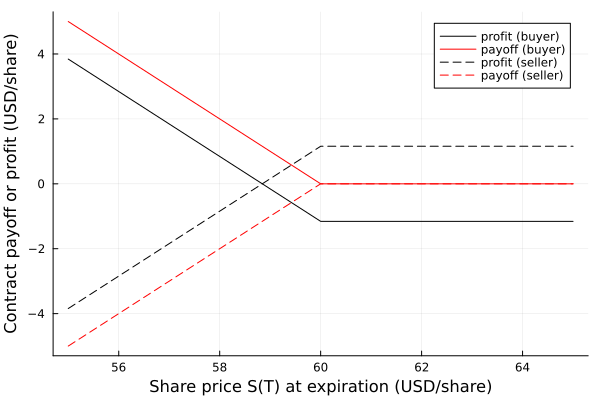

In [29]:
plot(profit_array[:,1],profit_array[:,2], c=:black, label="profit (buyer)")
plot!(payoff_array[:,1],payoff_array[:,end], c=:red, label="payoff (buyer)")
plot!(profit_array[:,1],-1*profit_array[:,2], c=:black, label="profit (seller)", linestyle=:dash)
plot!(payoff_array[:,1],-1*payoff_array[:,end], c=:red, label="payoff (seller)", linestyle=:dash)
xlabel!("Share price S(T) at expiration (USD/share)",fontsize=18)
ylabel!("Contract payoff or profit (USD/share)",fontsize=18)

## Objective 2: Premium, payoff and profit for an American Put contract